# Simple Linear Regression of Wind-Turbine Data

Data downloaded from Kaggle at https://www.kaggle.com/mrmorj/wind-plant-data

## Importing Packages

In [1]:
##Import packages

#Data Processing
import pandas as pd
import numpy as np

#Finding the data on our system
import pathlib

#Linear regression
from sklearn import linear_model

#Metrics to evaluate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

#Plotting library
import matplotlib.pyplot as plt

## Importing Data

In [2]:
##Import data from another directory

#Find the file
p = str(pathlib.Path().resolve()).replace("\\Notebooks\\SciKit-Learn Regression", "")
p += ("\\Data\\Raw\\Wind-Turbine-Data.csv")
p = pathlib.Path(p).resolve()

#Read into a pandas dataframe
df = pd.read_csv(p)

#Preview the dataset
df.head()

Plant_Code   Longitude   Latitude  InstCapMWi  AreaKM2  NetGENe_2016_MWe  \
0       57108  -98.452500  34.821700        99.0   49.554         41.580260   
1       58596 -101.310833  35.238333       211.2  176.567        105.692965   
2       57107 -112.931000  38.585230       102.0   21.970         24.403119   
3       58594  -96.952222  40.048889        74.8   46.081         36.294399   
4       57098 -110.284200  34.659600        63.0   38.983         12.786999   

          USWTDB_ID  
0     Blue Canyon V  
1       Grandview I  
2  Milford Phase II  
3      Steele Flats  
4          Dry Lake

## Removing Unused Columns from Data

Not all of the columns in this dataset are necessarily useful, such as the names of the area, or the plant code. The location likely contains useful information, but would require a transformation first in order to make sense as a term in a regression.

Thus, the only columns that we keep are the Installed Capacity in MW (InstCapMWi), the area of the plant (AreaKM2), and the dependent variable, the amount of power generated (NetGENe_2016_MWe).

In [3]:
#Drop columns
df = df.drop(["Plant_Code", "Longitude", "Latitude", "USWTDB_ID"], axis=1)

#Rename columns
df = df.rename({"InstCapMWi": "Installed Cap (MW)", 
                "AreaKM2": "Area (KM^2)", 
                "NetGENe_2016_MWe": "Generation (MWe)"},
                axis=1)
df.head()

Installed Cap (MW)  Area (KM^2)  Generation (MWe)
0                99.0       49.554         41.580260
1               211.2      176.567        105.692965
2               102.0       21.970         24.403119
3                74.8       46.081         36.294399
4                63.0       38.983         12.786999

## Removing Rows for Test Data

A vital part of machine learning is being able to test with data that the model is not trained on. This means that we can test the generalisability of our regression with this data.

We also rename the training portions of the data accordingly.

In [4]:
#Find test data
test_data = df[-50:]

#Seperate into x and y
test_y = test_data["Generation (MWe)"]
test_x = test_data[["Installed Cap (MW)", "Area (KM^2)"]]

#Remove test data from the original dataset
df = df.drop(list(range(380, 430)))

In [5]:
## Rename training data columns
training_y = df["Generation (MWe)"]
training_x = df[["Installed Cap (MW)", "Area (KM^2)"]]

## Testing for Multicollinearity

As explained in the main article, multicollinearity is a problem for data used in a regression, so we want to test for this before performing the regression. This can be done easily with `df.corr()`, producing a correlation matrix between each variable in the DataFrame.

A good limit to consider is a correlation of over 0.8 being highly collinear, such that we would have to do something about it. This is not the case here, as the variables are only slightly correlated, and such we can continue as planned.

In [14]:
training_x.corr()

Installed Cap (MW)  Area (KM^2)
Installed Cap (MW)            1.000000     0.347224
Area (KM^2)                   0.347224     1.000000

## Training Regression Model

Next, we use the data to train our linear regression model, with SciKit-Learn

In [6]:
#Linear Regression Object
reg = linear_model.LinearRegression()

#Fit the linear regression model with our training data
reg.fit(training_x, training_y)

LinearRegression()

## Evalutating Fit of Model

To evaluate the fit of the model, we compare predicted values using the model to the true values observed. The test values are an important indicator, as we can see if our model generalises to more data points from the same set, without having to be trained on these.

This is done using `model.predict(true_value, predicted_value)`

### Mean Squared Error

One easy way to evaluate the fit of our model is to look at the Mean Squared Error (MSE) of our model. This can be done for both the training and test data sets.

As can be seen below, this is generally quite low compared to the power generation, so the predictions can be considered to be quite good - on average between 8 and 10 MW away from the true value.

In [7]:
#Predict values using the regression model 

y_pred = reg.predict(training_x)
y_test_pred = reg.predict(test_x)

In [8]:
print("Training Mean Squared Error: ", mean_squared_error(training_y, y_pred))
print("Test Mean Squared Error: ", mean_squared_error(test_y, y_test_pred))

Training Mean Squared Error:  94.39995070078072
Test Mean Squared Error:  74.27146660840661


### Explained Variance Score

# How exactly is this similar to $r^2$?

The Explained Variance Score gives a measure of how much of the variance in the dependent variable can be explained by variance in the indepenent variables. A value of 1 would mean that all of the variance can be explained, and can mean a perfect correlation. This is similar in concept to an r^2 score, but the calculation is slightly different - if the mean of the error terms is 0, then the explained variance is the same as r^2.

As can be seen here, this is 0.88 for the training data, meaning that the vast majority of the difference in power generation can be explained through variation in the area and power cap installed.

In [9]:
print("Training Explained Variance :", explained_variance_score(training_y, y_pred))
print("Test Explained Variance :", explained_variance_score(test_y, y_test_pred))

Training Explained Variance : 0.8865822737503357
Test Explained Variance : 0.9038528404860015


### Visualising Fit on Graph

We can also attempt to visualise the fit of the regression, by plotting the line. As there are only 3 variables to be considered here, we can plot all of them at the same time, with the regression line. If you have more than 3 variables, you can choose one or two to plot against the dependent variable, and hold the others at their means.

As we can see from this graph, these points are clustered around the line, showing that it makes a good prediction of the power generated.

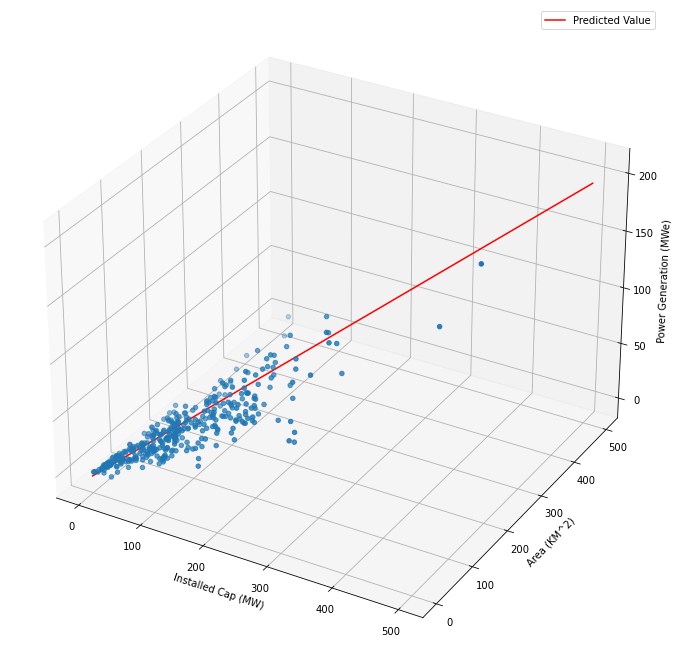

In [10]:
#Create axes
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(projection='3d')

#Generate line
x_space = np.linspace(0,500,100).transpose()
y_space = np.linspace(0,500,100).transpose()
line_df = pd.DataFrame({"X": x_space, "Y":y_space})
z_space = reg.predict(line_df)

#Plot data
ax.scatter(training_x["Installed Cap (MW)"], training_x["Area (KM^2)"], training_y)

#Plot Line
ax.plot3D(x_space, y_space, z_space, color="red", label="Predicted Value")

#Label axes
ax.set_xlabel("Installed Cap (MW)")
ax.set_ylabel("Area (KM^2)")
ax.set_zlabel("Power Generation (MWe)")

plt.legend()

## Viewing Weights (Coefficients) 

In [12]:
print(reg.coef_)

print(reg.intercept_)

[0.35477615 0.04217623]
-3.1029614557205747


As can be seen in the code cell above, the weights and intercept for this model are displayed. This means that our equation for the regression line is:

$$ y = 0.355X_1 + 0.0422X_2 - 3.10 $$

The power generation for any known $X_1$ and $X_2$ value can therefore be estimated. Remember from above that the first column in the DataFrame referred to the installed power cap, so this is variable $X_1$.

## Predictions

To make further use of the model, we can predict new dependent variable values. This can be done with any measured independent variable values.

Here, the predicted value for a wind farm with the given installed cap and area, is 37.7MW.

In [11]:
#Making an example prediction

#Our example point will be at the mean of both dependent variables
# The formatting of this is rather strange, so a pandas DataFrame is used to store the data
predict_point = pd.DataFrame({"Installed Cap (MW)": np.mean(training_x["Installed Cap (MW)"]),
                              "Area (KM^2)": np.mean(training_x["Area (KM^2)"])}, index=[1])

#Predict y value
predicted_y = reg.predict(predict_point)

predicted_y

array([37.71553169])

# References

Things that I've referenced go here, to be cleaned up later

- https://stats.stackexchange.com/questions/210168/what-is-the-difference-between-r2-and-variance-score-in-scikit-learn
- SciKit-Learn
- Numpy
- Kaggle dataset
- Multicollinearity source - https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea